# Code Challenge - Meta Parameters - effects of Mini batches on Wine Quality Dataset

Run same parametric experiment on wine preprocessed wine quality dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [66]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:, None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return train_data,  testLoader

In [67]:
# a function that creates the ANN model

def createANewModel():

    # model architecture
    ANNiris = nn.Sequential(
      nn.Linear(11,32),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(32,32),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(32,1),   # output units
        )

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

    return ANNiris,lossfun,optimizer

In [79]:
# train the model

def trainTheModel(ANNiris, lossfun, optimizer, train_loader, test_loader):

    # initialize accuracies as empties
    trainAcc = []
    testAcc  = []
    losses   = []

    # loop over epochs
    for epochi in range(numepochs):

    # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
            batchLoss.append( loss.item() )
            # end of batch loop...
        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )
        losses.append( np.mean(batchLoss) )

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
#         predlabels = torch.argmax( ANNiris(X),axis=1 )
        testAcc.append( 100*torch.mean(((ANNiris(X)>0) == y).float()).item() )

    # function output
    return trainAcc,testAcc,losses

In [80]:
def miniBatchExp(test_loader, train_data, bs=16):
    train_loader = DataLoader(train_data,batch_size=bs,shuffle=True,drop_last=True)
    
    # create a model
    ANNiris,lossfun,optimizer = createANewModel()

    # train the model
    trainAcc,testAcc,losses = trainTheModel(ANNiris, lossfun, optimizer, train_loader, test_loader)
    
    return trainAcc, testAcc

In [81]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
train_data, testLoader = load_data(data, labels)

In [83]:
numepochs = 500

bs = 2**np.arange(1,7)
train_acc = np.zeros((numepochs, len(bs)))
test_acc = np.zeros((numepochs, len(bs)))

for i in range(len(bs)):
    tr, ts = miniBatchExp(testLoader, train_data, int(bs[i]))
    train_acc[:, i] = tr
    test_acc[:, i] = ts

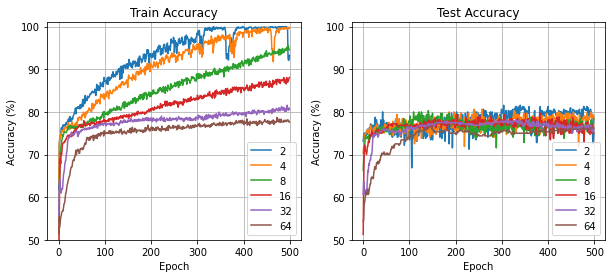

In [84]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(10, 4))


ax[0].plot(train_acc)
ax[0].set_title('Train Accuracy')
ax[1].plot(test_acc)
ax[1].set_title('Test Accuracy')


# common features
for i in range(2):
    ax[i].legend(bs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

# Code Challenge - Add batchNorm to ANN Multilayer

In [ ]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

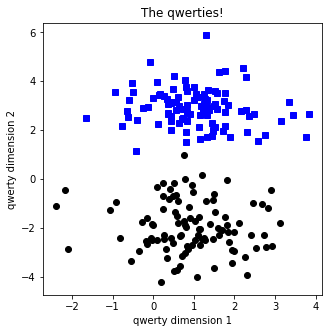

In [86]:
# create data

nPerClust = 100
blur = 1

A = [  1,  3 ]
B = [  1, -2 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [93]:
def createANNmodel(learningRate):

  # model architecture
  ANNclassify = nn.Sequential(
      nn.Linear(2,16),  # input layer
      nn.ReLU(),        # activation unit
      nn.BatchNorm1d(16),
      nn.Linear(16,1),  # hidden layer
      nn.ReLU(),        # activation unit
#       nn.BatchNorm1d(1),
      nn.Linear(1,1),   # output unit
      nn.Sigmoid(),     # final activation unit
        )

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

  # model output
  return ANNclassify,lossfun,optimizer

In [94]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel):

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  
  
  # final forward pass
  predictions = ANNmodel(data)
    
  # compute the predictions and report accuracy
  # NOTE: Wasn't this ">0" previously?!?!
  totalacc = 100*torch.mean(((predictions>.5) == labels).float())
  
  return losses,predictions,totalacc

Final accuracy: 99.5%


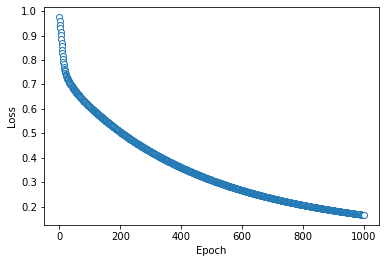

In [95]:
# create everything
ANNclassify,lossfun,optimizer = createANNmodel(.01)

# run it
losses,predictions,totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

In [96]:
# learning rates
learningrates = np.linspace(.001,.1,50)

# initialize
accByLR = []
allLosses = np.zeros((len(learningrates),numepochs))


# the loop
for i,lr in enumerate(learningrates):
  
  # create and run the model
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)
  allLosses[i,:] = losses.detach()


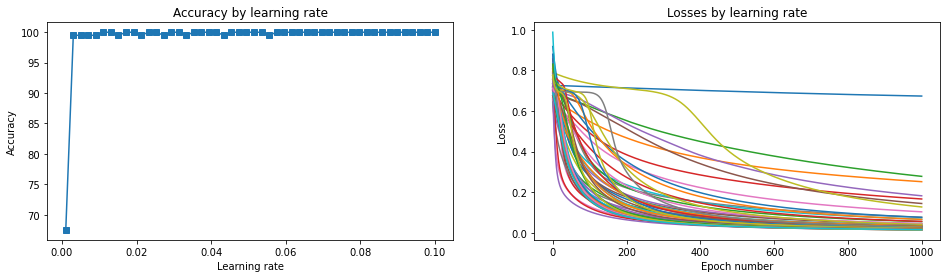

In [97]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

# Code Challenge - Activation function comparision

Compare ReLu, ReLu6 and LeakyRELU

In [79]:
def preprocess_data(data):
    
    # preprocess data as before
    data = data[data['total sulfur dioxide'] < 200]
    zscoreCols = data.keys().drop('quality')
    data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
    data['boolQuality'] = 0
    data['boolQuality'][data['quality']>5] = 1 
    data_t = torch.tensor(data[zscoreCols].values).float()
    labels = torch.tensor(data['boolQuality'].values).float()
    labels = labels[:,None]
    return data_t, labels

def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader,  testLoader

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

data, labels = preprocess_data(data)
trainLoader, testLoader = load_data(data, labels)

In [80]:
# NN with Batch Normalization

class ANN_BNorm(nn.Module):
    def __init__(self, actfn):
        super().__init__()

        self.ip = nn.Linear(11, 16)   # ip layer
        self.h1 = nn.Linear(16, 32)   # hidden layer 1
        self.h2 = nn.Linear(32, 20)  # hidden layer 2
        self.op = nn.Linear(20, 1)
        self.actfn = actfn
    
    def forward(self, x):  # doBN is bool set to true for train, and false for test
        
        actfn = getattr(torch.nn, self.actfn)
        
        x = actfn()(self.ip(x))
        x = actfn()(self.h1(x))
        x = actfn()(self.h2(x))
        
        return self.op(x)

In [81]:
# testing the model

net = ANN_BNorm('ReLU6')
net(torch.randn(10, 11)).shape

torch.Size([10, 1])

In [82]:
# training the model

nEp = 1000

def trainModel(wine_net):
    lossfn = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(wine_net.parameters(), lr = 0.01)
    
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        
        wine_net.train()
        
        batchLoss, batchAcc = [], []
        
        for x, y in trainLoader:
            
            yHat = wine_net(x)
            loss = lossfn(yHat, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        wine_net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = wine_net(x)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
          
    
    return trainAcc, testAcc, losses

In [83]:
af = ['ReLU', 'ReLU6', 'LeakyReLU']

trAct = np.zeros((nEp, len(af)))
teAct = np.zeros((nEp, len(af)))

for i, AFn in enumerate(af):
    net = ANN_BNorm(AFn)
    trAct[:, i], teAct[:, i], losses = trainModel(net)

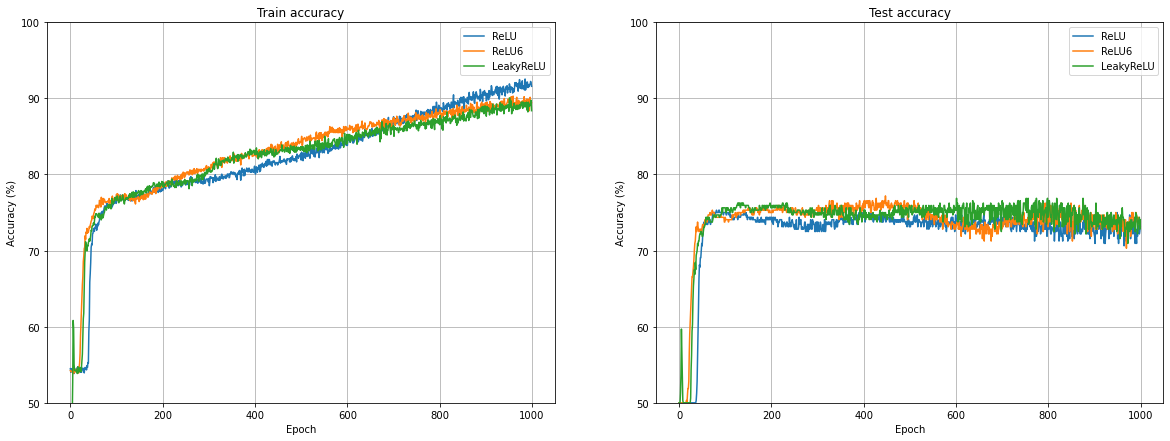

In [84]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trAct)
ax[0].set_title('Train accuracy')
ax[1].plot(teAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(af)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

# Code Challenge - Predicting sugar

In [53]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [54]:
data['residual sugar']

0       1.9
1       2.6
2       2.3
3       1.9
4       1.9
       ... 
1594    2.0
1595    2.2
1596    2.3
1597    2.0
1598    3.6
Name: residual sugar, Length: 1599, dtype: float64

In [55]:
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns (including quality!)
zscoreCols = data.keys().drop('residual sugar')
data[zscoreCols] = data[zscoreCols].apply(stats.zscore)
zscoreCols

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [56]:
dataT = torch.tensor( data[zscoreCols].values ).float()
sugar = torch.tensor( data['residual sugar'].values ).float()
sugar = sugar[:,None] # transform to matrix

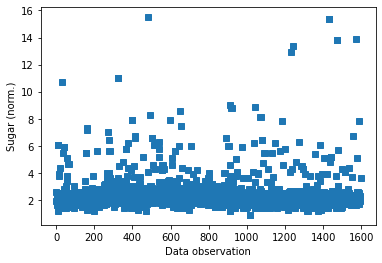

In [57]:
# check values in sugar
plt.plot(sugar,'s')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [73]:
def load_data(data, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, shuffle=True)

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    trainLoader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    testLoader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    
    return trainLoader, testLoader, X_train, X_test, y_train, y_test

trainLoader, testLoader, X_train, X_test, y_train, y_test = load_data(dataT, sugar)

In [74]:
# creating model

class ANNSugar(nn.Module):
    def __init__(self):
        super().__init__()
        self.ip = nn.Linear(11, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.h1 = nn.Linear(16, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.h2 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.op = nn.Linear(16, 1)
    
    def forward(self, x, doBN=False):
        x = F.relu(self.ip(x))
        
        if doBN:
            x = self.bn1(x)
        
        x = F.relu(self.h1(x))
        
        if doBN:
            x = self.bn2(x)
        
        x = F.relu(self.h2(x))
        
        if doBN:
            x = self.bn3(x)
        
        return self.op(x)        

In [75]:
# training the model

nEp = 1000

def trainModel(ANN, doBN=False):
    
    lossfn = nn.MSELoss()
    optim = torch.optim.SGD(ANN.parameters(), lr = 0.01)
    
    trLoss, teLoss = torch.zeros(nEp), torch.zeros(nEp)
    
    for i in range(nEp):
        ANN.train()
        
        batchLoss = []
        
        for x, y in trainLoader:
            
            yHat = ANN(x, doBN)
            loss = lossfn(yHat, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
        
        trLoss[i] = np.mean(batchLoss)
        
        ANN.eval()
        
        x, y = next(iter(testLoader))
        with torch.no_grad():
            yHat = ANN(x)
        
        teLoss[i] = lossfn(yHat, y).item()
    
    return trLoss, teLoss

In [76]:
net = ANNSugar()
trLoss, teLoss = trainModel(net)

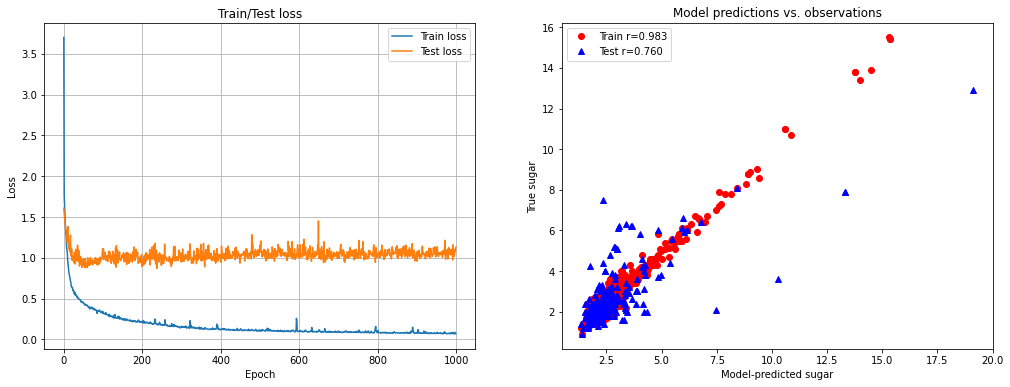

In [77]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trLoss,label='Train loss')
ax[0].plot(teLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = net(X_train)
yHatTest  = net(X_test)

ax[1].plot(yHatTrain.detach(),y_train,'ro')
ax[1].plot(yHatTest.detach(),y_test,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,y_train.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, y_test.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

AttributeError: 'Tensor' object has no attribute 'keys'

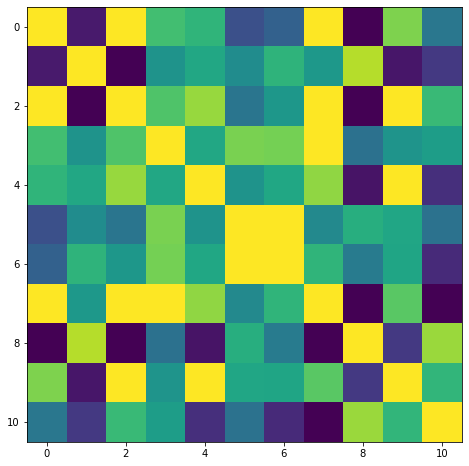

In [86]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data)),labels=data.keys(),rotation=90)
plt.yticks(range(len(data)),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()

# Code Challenge - Optimizers

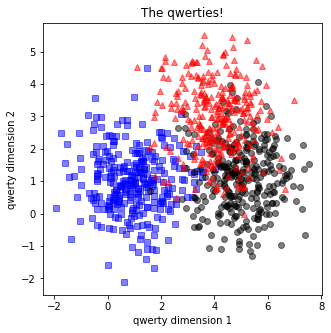

Number of batches: 50


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# create data

npc = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(npc)*blur , A[1]+np.random.randn(npc)*blur ]
b = [ B[0]+np.random.randn(npc)*blur , B[1]+np.random.randn(npc)*blur ]
c = [ C[0]+np.random.randn(npc)*blur , C[1]+np.random.randn(npc)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((npc)),
                         np.ones( (npc)),
                       1+np.ones( (npc))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

bs = 16
trainLoader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

print('Number of batches:', len(trainLoader))

# Momentum implementation in Pytorch
def createNet(optiAlg, lr):
    
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(2, 8) # 2 ip
            self.h1 = nn.Linear(8, 8)
            self.op = nn.Linear(8, 3) # 3 op classes

        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            return self.op(x)
    
    net = qwertyNet()
    lossfn = nn.CrossEntropyLoss()
    optifun = getattr( torch.optim,optiAlg )
    optim = optifun(net.parameters(), lr = lr) # adding momentum here
    
    return net, lossfn, optim

nEp = 50

def trainModel(alg, lr):
        
    net, lossfn, optim = createNet(alg, lr)
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        batchAcc, batchLoss = [], []
        net.train()
        
        for X, y in trainLoader:
            op = net(X)
            loss = lossfn(op, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
        
            matches = torch.argmax(op, axis=1) == y
            matches_num = matches.float()
            accPt = 100*torch.mean(matches_num)
            batchAcc.append(accPt)
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            pred = net(x)
        testAcc.append(100*torch.mean((torch.argmax(pred, axis=1) == y).float()))
        
    return net, trainAcc, testAcc, losses

In [22]:
# variables to loop over
lrs = np.logspace(np.log10(.0001),np.log10(.1),20)
optimTypes = ['SGD','RMSprop','Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(lrs),len(optimTypes)))


# now for the experiment!
for idx_o,opto in enumerate(optimTypes):
    for idx_l,lr in enumerate(lrs):
        trainAcc,testAcc,losses,net = trainModel(opto,lr)
        finalPerformance[idx_l,idx_o] = np.mean(testAcc[-10:])

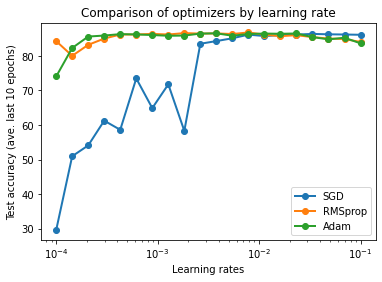

In [23]:
# plot the results! 
plt.plot(lrs,finalPerformance,'o-',linewidth=2)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

# Code Challenge - Adam + L2 regularization

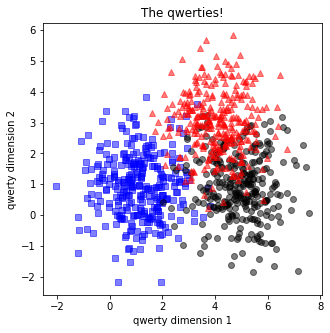

Number of batches: 50


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# create data

npc = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(npc)*blur , A[1]+np.random.randn(npc)*blur ]
b = [ B[0]+np.random.randn(npc)*blur , B[1]+np.random.randn(npc)*blur ]
c = [ C[0]+np.random.randn(npc)*blur , C[1]+np.random.randn(npc)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((npc)),
                         np.ones( (npc)),
                       1+np.ones( (npc))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

bs = 16
trainLoader = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

print('Number of batches:', len(trainLoader))

# Momentum implementation in Pytorch
def createNet(L2reg):
    
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(2, 8) # 2 ip
            self.h1 = nn.Linear(8, 8)
            self.op = nn.Linear(8, 3) # 3 op classes

        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            return self.op(x)
    
    net = qwertyNet()
    lossfn = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(net.parameters(), lr = .001, weight_decay=L2reg)
    
    return net, lossfn, optim

nEp = 50

def trainModel(L2reg):
        
    net, lossfn, optim = createNet(L2reg)
    losses = torch.zeros(nEp)
    trainAcc, testAcc = [], []
    
    for i in range(nEp):
        batchAcc, batchLoss = [], []
        net.train()
        
        for X, y in trainLoader:
            op = net(X)
            loss = lossfn(op, y)
            
            # backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
        
            matches = torch.argmax(op, axis=1) == y
            matches_num = matches.float()
            accPt = 100*torch.mean(matches_num)
            batchAcc.append(accPt)
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        net.eval()
        x, y = next(iter(testLoader))
        with torch.no_grad():
            pred = net(x)
        testAcc.append(100*torch.mean((torch.argmax(pred, axis=1) == y).float()))
        
    return net, trainAcc, testAcc, losses

In [27]:
# range of L2 regularization amounts
l2lambdas = np.linspace(0,.1,6)

# number of epochs
numepochs = 50

# initialize output results matrices
TrainRes = np.zeros((numepochs,len(l2lambdas)))
TestRes  = np.zeros((numepochs,len(l2lambdas)))


# loop over batch sizes
for li in range(len(l2lambdas)):

  # create and train a model
    net, trainAcc, testAcc, losses = trainModel(l2lambdas[li])

    # store data
    TrainRes[:,li] = trainAcc
    TestRes[:,li]  = testAcc


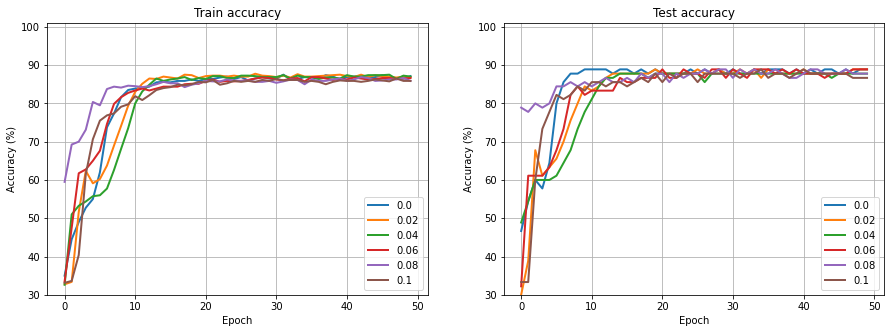

In [28]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(TrainRes,linewidth=2)
ax[0].set_title('Train accuracy')
ax[1].plot(TestRes,linewidth=2)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([30,101])
    ax[i].grid()

plt.show()

# Code Challenge - FFN - Binarized images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

In [3]:
# normalizing data to a range of 0-1

# dataNorm = (data > 0).astype(float)
# dataNorm = data/np.max(data)

Binarizing the image

In [4]:
print(np.unique(data))
# print(np.unique(dataNorm))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

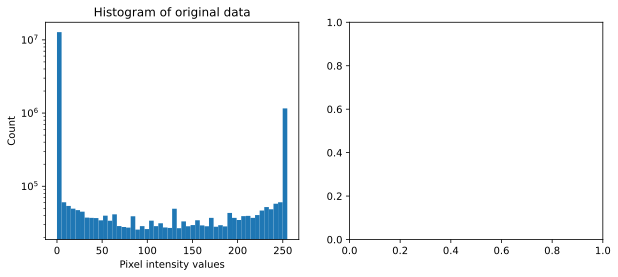

In [5]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

# ax[1].hist(dataNorm.flatten(),50)
# ax[1].set_xlabel('Pixel intensity values')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Histogram of normalized data')
# # ax[1].set_yscale('log')


plt.show()

In [6]:
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

In [7]:
X_test_N = X_test/torch.max(X_test)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test_N, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [8]:
print('Training data range from %g to %g' %(torch.min(trainLoader.dataset.tensors[0]), torch.max(trainLoader.dataset.tensors[0])))
print('Test data range from %g to %g' %(torch.min(testLoader.dataset.tensors[0]), torch.max(testLoader.dataset.tensors[0])))

Training data range from 0 to 255
Test data range from 0 to 1


In [9]:
def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    
    return net, lossfn, optim

# testing model with one batch

net, lossfn, optim = createMNISTNet()

x, y = next(iter(trainLoader))
yH = net(x)

print(yH.shape)

loss = lossfn(yH, y)

print('loss:', loss)

torch.Size([32, 10])
loss: tensor(4.4789, grad_fn=<NllLossBackward0>)


In [14]:
# function to train the model

def trainModel():
    
    nEp = 60
    net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
        
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses

net, trainAcc, testAcc, losses = trainModel()

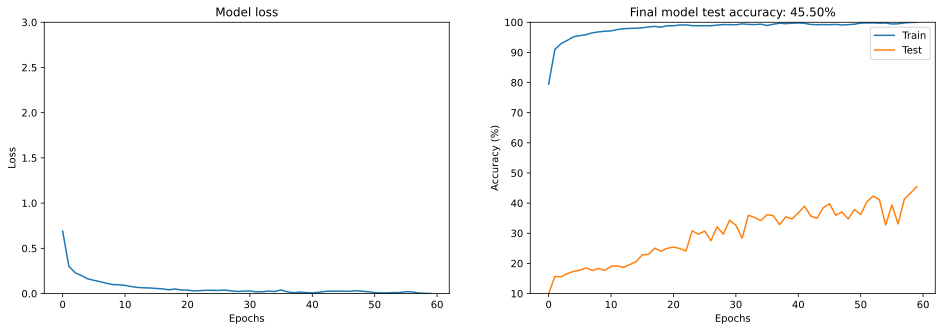

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

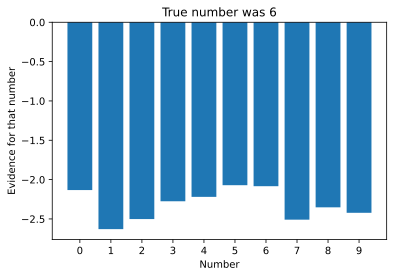

In [16]:
X,y = next(iter(testLoader))
predictions = net(X).detach()

predictions

# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[   1    4    6 ... 1995 1997 1998]


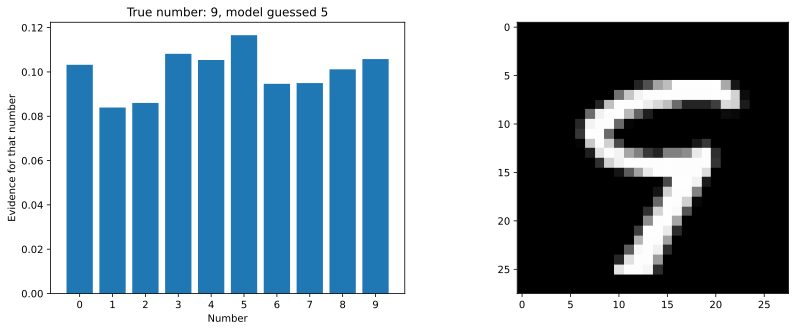

In [17]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Code Challenge - Model depth vs Breadth

__Depth__ - number of layers  
__Breadth__ - number of nodes in a layer

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# import dataset (comes with colab!)
data = np.loadtxt(open('../data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

/tmp/ipykernel_18711/1441878185.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
def createNet(nU, nL):
    
    class MNIST(nn.Module):
        def __init__(self, nU, nL):
            super().__init__()
            self.layers = nn.ModuleDict()
            self.nLayers = nL

            self.layers['ip'] = nn.Linear(784, nU)

            for i in range(self.nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nU, nU)

            self.layers['op'] = nn.Linear(nU, 10)
        
        def forward(self, x):
            x = F.relu(self.layers['ip'](x))
            
            for i in range(self.nLayers):
                x = F.relu(self.layers[f'hidden{i}'](x))
            
            x = self.layers['op'](x)
            
            return x
    
    net = MNIST(nU, nL)
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    lossfn = nn.CrossEntropyLoss()
    
    return net, lossfn, optim    

In [3]:
nU = 12 # number of units per layer
nL = 4  # number of layers
net = createNet(nU, nL)

In [4]:
# a function that trains the model

def funtion2trainTheModel(nUnits,nLayers):

    # number of epochs
    numepochs = 60

    # create a new model
    net,lossfun,optimizer = createNet(nUnits,nLayers)

    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    # end epochs

    # function output
    return trainAcc,testAcc,losses,net


In [5]:
### run the experiment! (note: takes ~30 mins)

# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = funtion2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}') 

Finished units 1/5 and layers 1/3
Finished units 1/5 and layers 2/3
Finished units 1/5 and layers 3/3
Finished units 2/5 and layers 1/3
Finished units 2/5 and layers 2/3
Finished units 2/5 and layers 3/3
Finished units 3/5 and layers 1/3
Finished units 3/5 and layers 2/3
Finished units 3/5 and layers 3/3
Finished units 4/5 and layers 1/3
Finished units 4/5 and layers 2/3
Finished units 4/5 and layers 3/3
Finished units 5/5 and layers 1/3
Finished units 5/5 and layers 2/3
Finished units 5/5 and layers 3/3


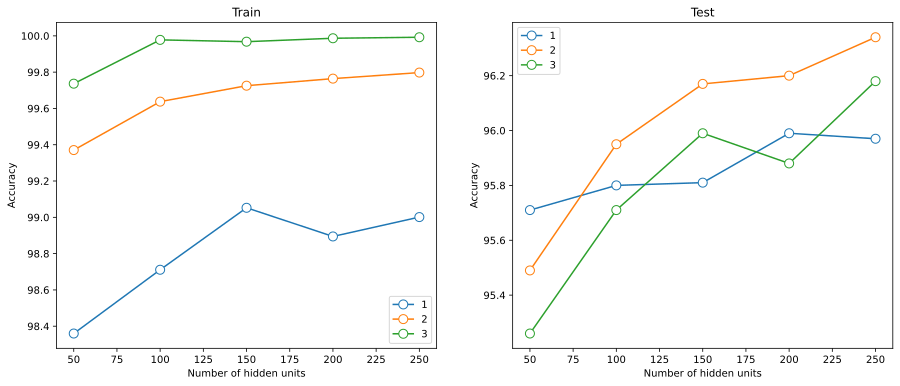

In [6]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()

# Code Challenge - Missing 7

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

In [8]:
### Splitting the data into train and test, and loading

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

In [21]:
X_train = dataT[labels != 7, :]
y_train = labelsT[labels != 7]

In [24]:
X_test = dataT[labels == 7, :]
y_test = labelsT[labels == 7] # not required but okay

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [28]:
### DL Model

def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    
    return net, lossfn, optim

# testing model with one batch

net, lossfn, optim = createMNISTNet()

x, y = next(iter(trainLoader))
yH = net(x)

print(yH.shape)

loss = lossfn(yH, y)

print('loss:', loss)

# function to train the model

def trainModel():
    
    nEp = 60
    net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
        
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
    # end of training loop
    
    return net, trainAcc, losses

net, trainAcc, losses = trainModel()

torch.Size([32, 10])
loss: tensor(2.3279, grad_fn=<NllLossBackward0>)


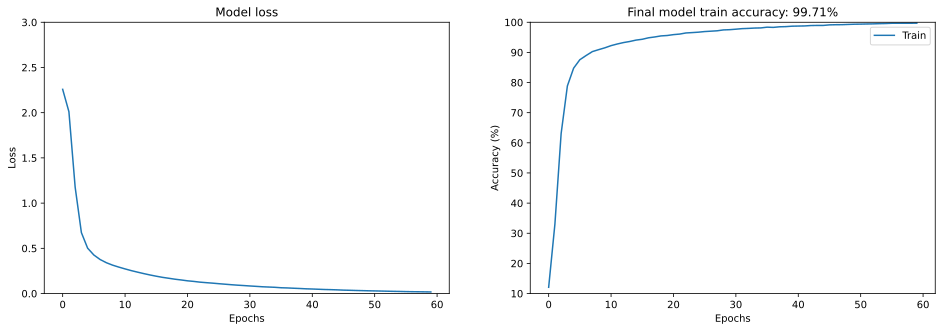

In [29]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [31]:
# run the model through for the test data
X = next(iter(testLoader))[0] # note: only need one output, hence the [0]
predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions,axis=1).detach()

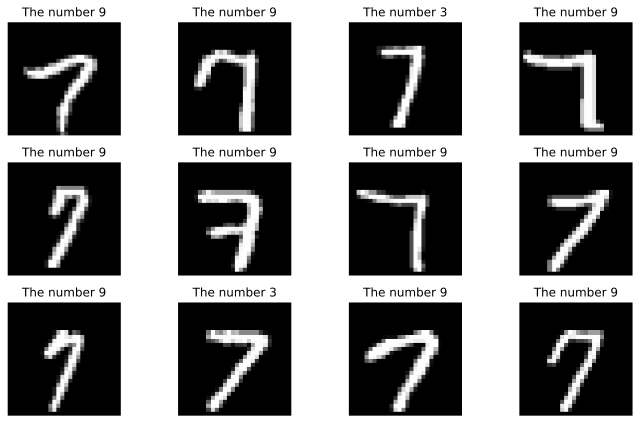

[0 1 2 3 4 5 6 8 9]


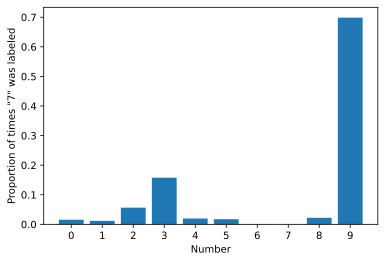

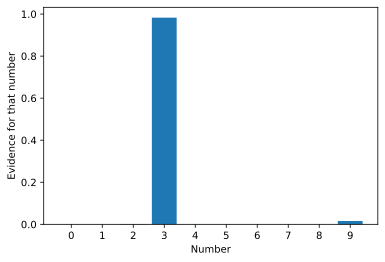

In [32]:
# show some 7's and their labels

fig,axs = plt.subplots(3,4,figsize=(10,6))

someRandom7s = np.random.choice(len(X),12)

for i,ax in enumerate(axs.flatten()):

    thisimg = X[ someRandom7s[i] ].view(28,28)
    ax.imshow(thisimg,cmap='gray')
    ax.set_title(f'The number {guesses[ someRandom7s[i] ]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# which numbers are most likely to be confused with 7?
print( np.unique(guesses) )

probMistaken = np.zeros(10)

for i in range(10):
    probMistaken[i] = torch.mean((guesses==i).float())

plt.bar(range(10),probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "7" was labeled')
plt.show()

# Evidence for all numbers from one sample
sample2show = 30

plt.bar(range(10),torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.show()